# Preprocesamiento: Tratamiento de *features* categóricas

Este notebook es una adaptación del [original de *Aurélien Gerón*](https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb), de su libro: [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 3rd Edition. Aurélien Géron](https://www.oreilly.com/library/view/hands-on-machine-learning/9781098125967/)

## Pasos previos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

housing = pd.read_csv("./data/housing.csv") 

# Generación de conjuntos de entrenamiento y prueba mediante muestreo estratificado por ingreso medio
train_set, test_set = train_test_split(housing, test_size=0.2,
    stratify=pd.cut(housing["median_income"], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5]),
    random_state=42
    )

housing = train_set.drop("median_house_value", axis=1) # Eliminamos la columna de la variable dependiente
housing_labels = train_set["median_house_value"].copy() # Guardamos la variable dependiente (etiquetas)

Hemos dejado de lado la columna 'ocean_proximity' porque es una variable categórica. La mayoría de los algoritmos de *Machine Learning* prefieren trabajar con números, por lo que es mejor convertir estas categorías de texto a números. Esto se llama **codificación**(***encoding***).

## OrdinalEncoder

In [2]:
from sklearn.preprocessing import OrdinalEncoder
cat_encoder = OrdinalEncoder()
housing_cat_ordinal_encoded = cat_encoder.fit_transform(housing[["ocean_proximity"]])
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [3]:
housing_cat_ordinal_encoded[:8]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.]])

`OrdinalEncoder` codifica las categorías como números **con un orden**. Esto hará que los algoritmos de *Machine Learning* asuman que dos valores cercanos son más similares que dos valores lejanos. Por ejemplo, si asignamos a 'NEAR BAY' el valor 1, y a 'INLAND' el valor 4, los algoritmos asumirían que 'NEAR BAY' es más similar a 'NEAR OCEAN' (valor 2) que a 'INLAND', lo cual no es cierto.

Si sabemos que las categorías tienen un orden, podemos usar una codificación **ordinal**  (por ejemplo, para categorías ordenadas como "malo", "promedio", "bueno" y "excelente"). En este caso, la cercanía a la costa parece tener un orden. Podríamos hacer una comprobación gráfica representando las categorías sobre un mapa de California, y ver si hay alguna relación entre la categoría y la cercanía a la costa.
<!-- TODO: diferencia con LabelEncoder -->

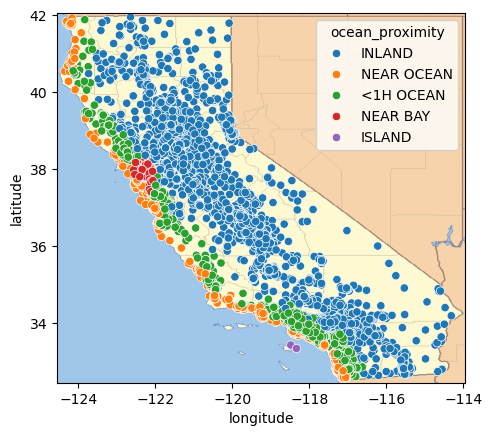

In [4]:
import seaborn as sns
import PIL
import matplotlib.pyplot as plt

sns.scatterplot(x="longitude", y="latitude", hue="ocean_proximity", data=housing)
axis = -124.55, -113.95, 32.45, 42.05 # límites de longitud y latitud de la imagen
plt.imshow(PIL.Image.open("./img/california.png", mode='r'), extent=axis)
plt.show()

Si bien hay cierta relación entre la categoría y la cercanía a la costa, no está claro cómo se relacionan las categorías `INLAND` y `NEAR BAY` con el resto. Por lo tanto, es mejor usar una codificación **no ordinal**.

## OneHotEncoder


Otra solución común cuando no tenemos claro el orden de las categorías es crear un atributo binario por categoría (convertir esa columna en tantas columnas como valores): un atributo igual a 1 cuando la categoría es "<1H OCEAN" (y 0 en caso contrario), otro atributo igual a 1 cuando la categoría es "INLAND" (y 0 en caso contrario), y así sucesivamente. Esto se llama ***one-hot encoding***, porque solo un atributo será igual a 1 (caliente), mientras que los demás serán 0 (fríos). Los nuevos atributos a veces se llaman atributos **dummy**. scikit-learn proporciona la clase `OneHotEncoder` para convertir valores categóricos en vectores *one-hot*.

In [5]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing[["ocean_proximity"]])
housing_cat_1hot

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 16512 stored elements and shape (16512, 5)>

Este método devuelve un ***sparse array*** de **SciPy**, que es una estructura que comprime los arrays de NumPy para ahorrar memoria cuando la mayoría de sus posiciones contienen ceros, almacenando solo los valores distintos de cero con sus posiciones. Si queremos convertirlo a un array de NumPy, podemos usar el método `toarray()`.

In [6]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

También se puede utilizar el argumento `sparse_output=False` en el constructor de `OneHotEncoder`.

In [7]:
OneHotEncoder(sparse_output=False).fit_transform(housing[["ocean_proximity"]])

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

Por su parte, la función `get_dummies()` de pandas hace lo mismo (pero devolviendo un DataFrame de Pandas).

In [8]:
pd.get_dummies(housing["ocean_proximity"]).head()

<1H OCEAN  INLAND  ISLAND  NEAR BAY  NEAR OCEAN
12655      False    True   False     False       False
15502      False   False   False     False        True
2908       False    True   False     False       False
14053      False   False   False     False        True
20496       True   False   False     False       False

Sin embargo, OneHotEncoder, al poder separar el proceso de entrenamiento (con `fit()`) y el de transformación (con `transform()`), recuerda las categorías con las que ha sido entrenado.

Esto no ocurre con `get_dummies()`: si se utiliza en un conjunto de datos de test en el que no aparece una categoría que sí aparecía en el conjunto de entrenamiento, no creará la columna correspondiente, y el conjunto de datos de test y el de entrenamiento tendrán un número distinto de columnas.

In [9]:
df_test = pd.DataFrame({"ocean_proximity": ["INLAND", "NEAR BAY"]})
pd.get_dummies(df_test) # siempre mapea las categorías existentes en el momento en que se llama

ocean_proximity_INLAND  ocean_proximity_NEAR BAY
0                    True                     False
1                   False                      True

In [10]:
cat_encoder.transform(df_test).toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Podemos ver como OneHotEncoder mantiene las categorías con las que ha sido entrenado, aunque haya categorías sin ningún registro.

Además, si en el conjunto de test aparece una categoría que no ha visto antes, lanzará una excepción. Esto es útil para detectar problemas en el conjunto de test, pero si queremos que simplemente ignore las categorías desconocidas, podemos usar el argumento `handle_unknown='ignore'` en el constructor de `OneHotEncoder`.

In [11]:
df_test_unknown = pd.DataFrame({"ocean_proximity": ["<2H OCEAN", "ISLAND"]})
pd.get_dummies(df_test_unknown)

ocean_proximity_<2H OCEAN  ocean_proximity_ISLAND
0                       True                   False
1                      False                    True

In [12]:
# cat_encoder.handle_unknown = "ignore" # así evitamos la excepción y simplemente devuelve ceros
try:
    cat_encoder.transform(df_test_unknown).toarray()
except Exception as e:
    print("EXCEPTION:", str(e))

EXCEPTION: Found unknown categories ['<2H OCEAN'] in column 0 during transform


La información de cómo ha sido entrenado un transformador se almacena en sus atributos. Con el método `get_feature_names_out()` podemos obtener los nombres de las columnas de salida.

In [13]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

In [14]:
cat_encoder.get_feature_names_out()

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [15]:
cat_encoder.handle_unknown = "ignore"
df_output = pd.DataFrame(cat_encoder.transform(df_test_unknown).toarray(),
                         columns=cat_encoder.get_feature_names_out(),
                         index=df_test_unknown.index)
df_output 

ocean_proximity_<1H OCEAN  ocean_proximity_INLAND  ocean_proximity_ISLAND  \
0                        0.0                     0.0                     0.0   
1                        0.0                     0.0                     1.0   

   ocean_proximity_NEAR BAY  ocean_proximity_NEAR OCEAN  
0                       0.0                         0.0  
1                       0.0                         0.0

Hay que tener en consideración que, si un atributo categorial tiene muchas categorías, el número de columnas puede crecer mucho, lo que puede ralentizar el entrenamiento y hacer que el modelo sea más difícil de entrenar. Además, si una categoría tiene muy pocos ejemplos, es posible que no sea útil.